<a href="https://colab.research.google.com/github/amysfrogs/LegoDataMining/blob/main/LegoDataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [396]:
%reset -f

In [397]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import random as rnd
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('augmented.csv')

# Specify which columns are categorical
categorical_cols = ['category', 'ages', 'review_difficulty', 'theme_name', 'country']

df['category'] = pd.Categorical(df['category'])
category_categories = df['category'].cat.categories

df['ages'] = pd.Categorical(df['ages'])
ages_categories = df['ages'].cat.categories

df['review_difficulty'] = pd.Categorical(df['review_difficulty'])
review_difficulty_categories = df['review_difficulty'].cat.categories

df['theme_name'] = pd.Categorical(df['theme_name'])
theme_name_categories = df['theme_name'].cat.categories

df['country'] = pd.Categorical(df['country'])
country_categories = df['country'].cat.categories

# Drop rows with missing values (bad data) in both features and labels
df.dropna(subset=['list_price'], inplace=True)  # Remove rows with NULLs in 'list_price'
df.dropna(subset=categorical_cols, inplace=True)  # Remove rows with NULLs in categorical columns

In [399]:
########## Clustering


data = pd.read_csv('augmented.csv')

data_numeric = data.drop(categorical_cols+['star_rating']+['val_star_rating']+['play_star_rating']+['id']+['year']+ ['list_price']+ ['adjusted_price_per_part'], axis=1)

X = data_numeric.to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, n_init = 'auto', random_state=int(rnd.random()*100))
y_pred = kmeans.fit_predict(X_scaled)

data['cluster_label'] = kmeans.labels_

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers:")
print(pd.DataFrame(cluster_centers, columns=data_numeric.columns))

data['cluster_label'] = kmeans.labels_

#check the silhouette score for the given cluster labels
score = silhouette_score(X_scaled, kmeans.labels_, metric = 'euclidean')
print("Silhouette score for clusters: ", score)

# Get the number of students in each cluster
cluster_counts = data['cluster_label'].value_counts()

print("Number of lego sets in each cluster:")
for cluster_label, count in cluster_counts.items():
    print(f"Cluster {cluster_label}: {count}")

Cluster Centers:
         parts  inflation_adjusted_price
0  1035.420106                133.499045
1   188.836217                 25.639115
2  4154.536585                395.535467
3  7541.000000                995.276820
4   556.853444                 72.664384
5  2169.638484                232.311490
Silhouette score for clusters:  0.5545256797682356
Number of lego sets in each cluster:
Cluster 1: 4430
Cluster 4: 1824
Cluster 0: 957
Cluster 5: 343
Cluster 2: 205
Cluster 3: 20


In [348]:
column_names = df.columns.values.tolist() #create list of column names
df_cluster = pd.merge(df, data, how = 'left', on = column_names) #add cluster labels to dataframe to use for xgboost

cluster_categorical = ['category', 'ages', 'review_difficulty', 'theme_name', 'country', 'cluster_label']

df_cluster['cluster_label'] = pd.Categorical(df_cluster['cluster_label'])
cluster_label_categories = df_cluster['cluster_label'].cat.categories

df_cluster['category'] = pd.Categorical(df_cluster['category'], category_categories)
df_cluster['ages'] = pd.Categorical(df_cluster['ages'], ages_categories)
df_cluster['review_difficulty'] = pd.Categorical(df_cluster['review_difficulty'], review_difficulty_categories)
df_cluster['theme_name'] = pd.Categorical(df_cluster['theme_name'], theme_name_categories)
df_cluster['country'] = pd.Categorical(df_cluster['country'], country_categories)

df_cluster.drop(axis = 1, labels = ['id'], inplace = True) # drop item identifier column (id)

In [352]:
# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cluster.drop(['star_rating', 'val_star_rating', 'play_star_rating'], axis=1), df_cluster['star_rating'], test_size=0.25, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df_cluster.drop(['adjusted_price_per_part', 'list_price', 'inflation_adjusted_price'], axis=1), df_cluster['adjusted_price_per_part'], test_size=0.25, random_state=42)

X_train['category'] = pd.Categorical(X_train['category'], category_categories)
X_train['ages'] = pd.Categorical(X_train['ages'], ages_categories)
X_train['review_difficulty'] = pd.Categorical(X_train['review_difficulty'], review_difficulty_categories)
X_train['theme_name'] = pd.Categorical(X_train['theme_name'], theme_name_categories)
X_train['country'] = pd.Categorical(X_train['country'], country_categories)
X_train['cluster_label'] = pd.Categorical(X_train['cluster_label'], cluster_label_categories)

X_test['category'] = pd.Categorical(X_test['category'], category_categories)
X_test['ages'] = pd.Categorical(X_test['ages'], ages_categories)
X_test['review_difficulty'] = pd.Categorical(X_test['review_difficulty'], review_difficulty_categories)
X_test['theme_name'] = pd.Categorical(X_test['theme_name'], theme_name_categories)
X_test['country'] = pd.Categorical(X_test['country'], country_categories)
X_test['cluster_label'] = pd.Categorical(X_test['cluster_label'], cluster_label_categories)

# Convert categorical columns to their category codes
X_train[cluster_categorical] = X_train[cluster_categorical].apply(lambda x: x.cat.codes)
X_test[cluster_categorical] = X_test[cluster_categorical].apply(lambda x: x.cat.codes)

# Create a DMatrix with enable_categorical=True
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Define a grid of hyperparameters to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the GridSearchCV object
best_params = grid_search.best_params_

# Train the XGBoost model
model = xgb.train(best_params, dtrain)

# Save the trained model
saved_model = pickle.dumps(model)

#load the pickled model
model_from_pickle = pickle.loads(saved_model)

# Make predictions on the testing set
y_pred = model_from_pickle.predict(dtest)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)


# Calculate the R^2
r2 = r2_score(y_test, y_pred)

# Print the xgboost R^2
print('xgboost R^2:', r2)

Mean squared error: 0.08623672711891678
xgboost R^2: 0.6580683677290962


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:45:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [363]:
print(review_difficulty_categories)

Index(['Average', 'Challenging', 'Easy', 'Unknown', 'Very Challenging',
       'Very Easy'],
      dtype='object')


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

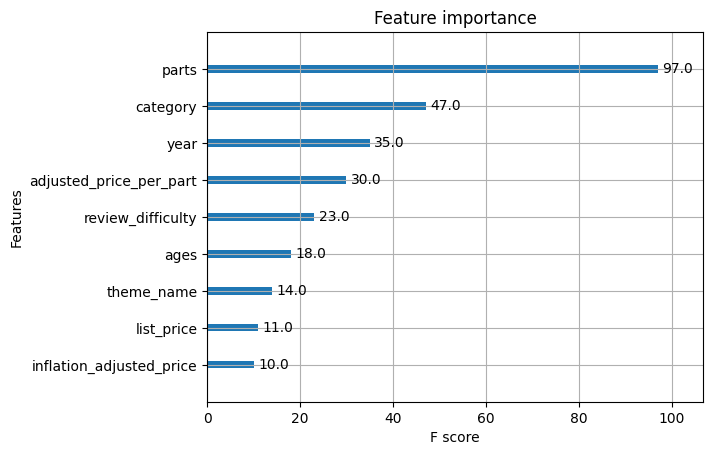

In [353]:
xgb.plot_importance(model_from_pickle)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

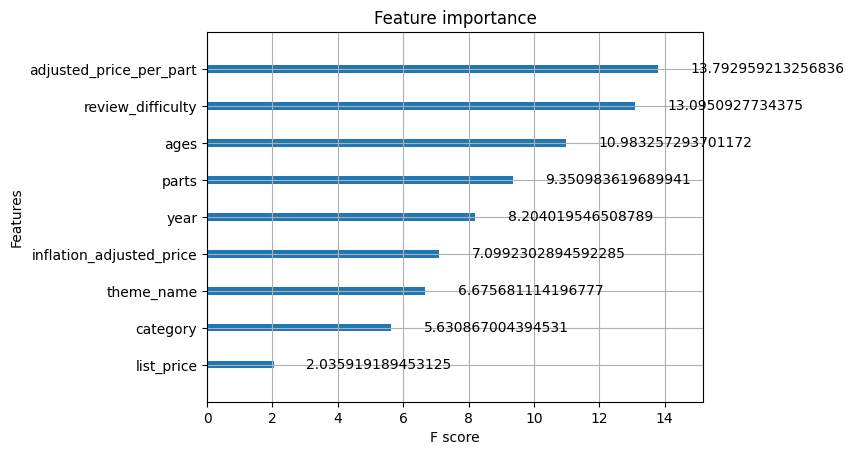

In [354]:
xgb.plot_importance(model_from_pickle, importance_type = "gain")

In [390]:
#create a blank dataframe for trial data and populate it with values
data_trial = pd.DataFrame(columns = column_names)
data_trial = data_trial.append({'category': 'Friends', 'year': 2023,
                                'parts': 345, 'ages': '12+', 'review_difficulty': 'Very Challenging',
                                'theme_name': 'Friends', 'country': 'US', 'star_rating': 0,
                                'list_price': 79.99, 'inflation_adjusted_price': 79.99 },
                               ignore_index = True)

#calculate price per part for trial data
data_trial['adjusted_price_per_part'] = data_trial['list_price'] / data_trial['parts']

input_label = data_trial['star_rating']

<ipython-input-390-c8761dd2fc36>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_trial = data_trial.append({'category': 'Friends', 'year': 2023,


In [391]:
data_numeric_trial = data_trial.drop(categorical_cols+['star_rating']+['val_star_rating']+['play_star_rating']+['id']+['year']+ ['list_price']+ ['adjusted_price_per_part'], axis=1)

X_trial = data_numeric_trial.to_numpy()

scaler = StandardScaler()
X_scaled_trial = scaler.fit_transform(X_trial)

In [392]:
data_trial['cluster_label'] = kmeans.predict(X_scaled_trial)

data_trial['category'] = pd.Categorical(data_trial['category'], category_categories)
data_trial['ages'] = pd.Categorical(data_trial['ages'], ages_categories)
data_trial['review_difficulty'] = pd.Categorical(data_trial['review_difficulty'], review_difficulty_categories)
data_trial['theme_name'] = pd.Categorical(data_trial['theme_name'], theme_name_categories)
data_trial['country'] = pd.Categorical(data_trial['country'], country_categories)
data_trial['cluster_label'] = pd.Categorical(data_trial['cluster_label'], cluster_label_categories)
data_trial['year'] = data_trial['year'].astype('int')
data_trial['parts'] = data_trial['parts'].astype('int')
data_trial['adjusted_price_per_part'] = data_trial['adjusted_price_per_part'].astype('float')

data_trial[cluster_categorical] = data_trial[cluster_categorical].apply(lambda x: x.cat.codes)
data_trial.drop(axis = 1, labels = ['id', 'val_star_rating', 'play_star_rating', 'star_rating'], inplace = True)

In [394]:
data_input = xgb.DMatrix(data_trial, label = input_label, enable_categorical=True)
rating_prediction = model_from_pickle.predict(data_input)
print('Predicted rating for user generated set, out of a max of 5: ', rating_prediction)

Predicted rating for user generated set, out of a max of 5:  [4.18701]
